# INM705 Coursework
### Aaron Mir (Student Number: 160001207) and Sarah Rhalem (Student Number: 190051884)

This is from the INM701 coursework guidelines but I am keeping it here because it has some good points in it.

In this coursework, you are expected to demonstrate what you have learned in the module by applying techniques as covered in the module to a dataset and domain of your choice. This will include some or all of:

    • Define the domain and dataset(s) (you are free to choose the domain and the dataset that you want to investigate).

    • Define  questions and analysis tasks (a brief overview  of  the  domain, analytical questions that are being asked, a list of your objectives and the 
    expected output(s)of your analysis)
    
    • Perform an initial investigation of the dataset and the characteristics of the data. Develop a viable plan: which data processing steps you will need to
    perform, how you will transform the data to make it useable, which artificial intelligence techniques you can potentially use and what sorts of potential
    observations these can lead to.

    • Perform the analysis.  Get the data ready for analysis, carry out your analysis/modelling as needed, validate your results and communicate observations, 
    iterating through this process. Analytical operations can include data processing to an extent that is needed (not all datasets are messy) to prepare a useful and
    robust dataset to work within, and data derivation (such as feature engineering).

    • Split your dataset (train/validate/test, somedatasets come pre-split). If you have a holdout test set then you most likely don’t want to use this until the near 
    the end of your work.

    • You might establish a baseline result first, computing metrics on training and validation sets,  analyse  errors, work  on  succeeding iterations, and 
    alternative models. (If initial metrics are amazing and there are no errors is the problem too easy?)

    • Be  close to your data  (visualise  the  dataset,  collect  summary  statistics,  look  at  errors, analyse how different parameters affect performance, try 
    out different model variants).


## Semantic Segmentation of Brain Tumours using U-Net and Fully Convolutional Network

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch 
import torchvision
import nibabel as nib
from nibabel.testing import data_path
from PIL import Image
# importing packages for visualisation and pre-processing
import SimpleITK as sitk
import time
import itk                  # visualisation in jupyter
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons

In [2]:
##--------------------Coding References---------------------##
# Percentage of borrowed code: X% - 
# [1] 

In [3]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Nibabel Version: {nib.__version__}")

Python: 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]
Numpy Version: 1.19.5
PyTorch Version: 1.7.1+cu110
Nibabel Version: 3.2.1


## Initial investigation of the first training image

In [4]:
image_1 = os.path.join('data\\train\\BRATS_001.nii.gz') # accessing the first training image

In [5]:
image_1 = nib.load(image_1) # loading the training image

In [6]:
image_1.shape # looking at the shape (240x240 pixels), 155 frames, 4 dimensions (FLAIR, T1w, T1gd, T2w)

(240, 240, 155, 4)

In [7]:
print(image_1) # looking at the header

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155, 4)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quater

In [8]:
image_1_data = image_1.get_fdata()

In [9]:
image_1_data_arr = np.asarray(image_1_data) # transforming to np array

In [10]:
image_1_data_arr.shape # looking at the shape

(240, 240, 155, 4)

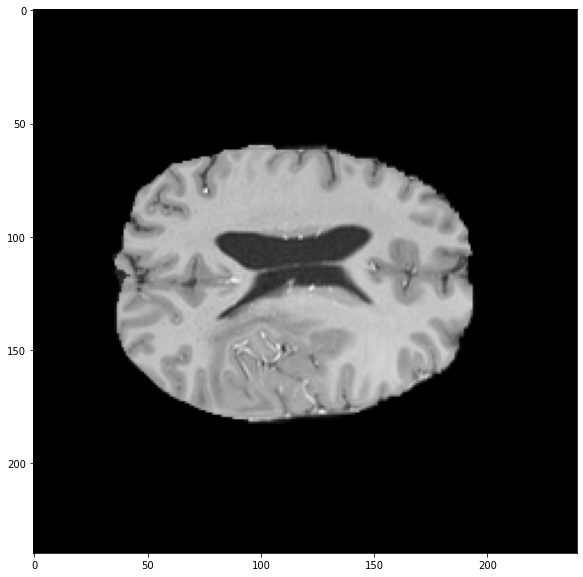

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image_1_data_arr[:,:,95,2], cmap='gray'); # plotting the FLAIR (0th dimension) of the 106th frame of the 1st training image FLAIR - 0, T1w - 1, T1gd - 2, T2w - 3

## Initial investigation of the label for the first training image

In [124]:
image_1_label = os.path.join('data\\train_labels\\BRATS_001.nii.gz') # accessing the label for the first training image

In [125]:
image_1_label = nib.load(image_1_label) # loading the label for the first training image

In [126]:
image_1_label.shape # investigating the shape (240x240 pixels), 155 frames each frame represents the pixels where the tumour is present as demonstrated below 

(240, 240, 155)

In [127]:
print(image_1_label) # looking at the header for the label

<class 'nibabel.nifti1.Nifti1Image'>
data shape (240, 240, 155)
affine: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c   

In [128]:
image_1_label_data = image_1_label.get_fdata()

In [129]:
image_1_label_data_arr = np.asarray(image_1_label_data) # converting to np array

In [130]:
image_1_label_data_arr.shape # investigating the shape

(240, 240, 155)

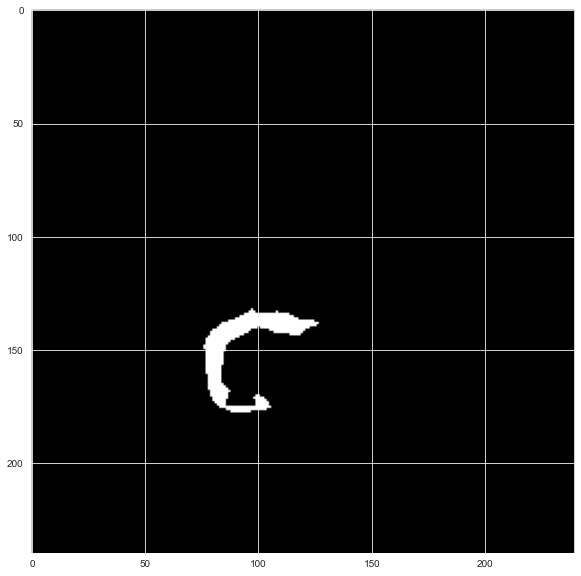

In [147]:
plt.figure(figsize=(10,10))
plt.imshow(image_1_label_data_arr[:,:,95], cmap='gray'); # plotting the label of the 1st training image - 95th frame shows clearly the tumour

In [21]:
#img = Image.fromarray(img_data_arr[:,:,15,0], 'L')
#img.save("image.jpeg")

In [22]:
#np.set_printoptions(threshold=sys.maxsize)
#image_1_label_data[130:, 130:, 55]     # can see 0, 1, 2, 3 in the numpy array - this corresponds to the 4 classes

## Data Preprocessing - Starting from scratch kinda

Summary of steps to perform: 
- N4ITK bias correction
- 1% of the top and bottom intensities removed
- Normalise to 0 mean and unit variance
- Data Augmentation (rotation, shearing etc.) to generate more data points from 484 Labelled MRIs with tumours, helps with generalisation
- Train/val/test split 

In [133]:
image_1 = os.path.join('data\\train\\BRATS_001.nii.gz') # accessing the first training image

In [134]:
image_1 = nib.load(image_1) # loading the training image

In [135]:
image_1_data = image_1.get_fdata() # converting to np array

In [136]:
height, width, depth, channels = image_1_data.shape         # getting the dimensions
print(f'This image has the following dimensions: \nHeight = {height}\nWidth = {width}\nDepth = {depth}\nChannels = {channels}')

This image has the following dimensions: 
Height = 240
Width = 240
Depth = 155
Channels = 4


In [30]:
def visualisation(layer):                   # function that allows interaction to view all layers of an MRI
    plt.figure(figsize=(5,5))
    channel = 0
    plt.imshow(image_1_data[:,:, layer, channel], cmap='gray')
    plt.title('Visualisation of Layers of Brain MRI', family='Arial', fontsize=20)
    plt.axis('off')
    return layer

interact(visualisation, layer = (0, image_1_data.shape[2]-1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [137]:
## Doing the same as above for the labels
image_1_label = os.path.join('data\\train_labels\\BRATS_001.nii.gz') # accessing the label for the first training image
image_1_label = nib.load(image_1_label) # loading the label for the first training image
image_1_label_data = image_1_label.get_fdata()

In [138]:
height, width, depth = image_1_label_data.shape         # getting the dimensions
print(f'This image has the following dimensions: \nHeight = {height}\nWidth = {width}\nDepth = {depth}.')
print(f'With the unique values: {np.unique(image_1_label_data)}.')
print('''Corresponding to the label categories:             
 0: for normal,
 1: for edema,
 2: for non-enhancing tumour
 3: for enhancing tumour''')                            # outlining the labels

This image has the following dimensions: 
Height = 240
Width = 240
Depth = 155.
With the unique values: [0. 1. 2. 3.].
Corresponding to the label categories:             
 0: for normal,
 1: for edema,
 2: for non-enhancing tumour
 3: for enhancing tumour


In [139]:
classes = {
    'Normal' : 0.,
    'Edema' : 1.,
    'Non-enhancing Tumour' : 2.,
    'Enhancing Tumour' : 3.,
}
select_class = ToggleButtons(
    options = ['Normal','Edema', 'Non-enhancing Tumour', 'Enhancing Tumour'],
    description = 'Select Class:',
    disabled = False,
    button_style = 'info', 
    
)
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)

def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes[seg_class]
    mask = np.where(image_1_label_data[:,:, layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

interactive(plot_image, seg_class = select_class, layer = select_layer) # remember the white space represents what is being shown

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

In [34]:
np.unique(image_1_label_data[:,:, 55])

array([0., 1., 2., 3.])

#### Exploring N4 Bias Correction:

N4ITK paper : https://ieeexplore.ieee.org/abstract/document/5445030

Documentation: https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html

In [103]:
# Either we run N4 correction on array, iterate through entire pre-processing and then output to file. 
# Or we read directly from file and output to folder at N4 stage, may be better if processing takes long. Both methods below. 
# Some steps commented out below, questions around the process.

# Run on array input
def N4_Bias_Correction():

    start = time.time() # Can remove later
    shrink_factor = 2 # Any potential value
    InputImg= sitk.GetImageFromArray(image_1_data_arr[:,:,:,1]) # Filtered for T1 modality, need to check how to handle all modalities. Throwing up an error.
    
    #InputImg= sitk.Shrink(InputImg, [int(shrink_factor)] * InputImg.GetDimension()) # Shrink the image? Improves run time 5 fold. Reduces quality but can convert back.
    
    InputImg = sitk.Cast(InputImg, sitk.sitkFloat32)
    MaskImg= sitk.OtsuThreshold (InputImg, 0, 1, 200) # Otsu Threshold
    
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    
    OutputImg= corrector.Execute(InputImg, MaskImg)
    OutputImg= sitk.GetArrayFromImage(OutputImg)
    
    # log_bias_field = corrector.GetLogBiasFieldAsImage(InputImg) # Would want to save this if we use the shrink approach
    
    end = time.time()
    total_time= print(end-start)
    print("N4 Bias Field Correction complete")
    return OutputImg, total_time

# Run on file input
def N4_Bias_Correction_file():
    
    start = time.time() 
    shrink_factor = 2 
    
    InputImg = sitk.ReadImage('data\\train\\BRATS_001.nii.gz') 
    InputImg = sitk.Image(240,240, 155, sitk.sitkFloat32)                       # This is not correct because it just generates a random 240, 240 x 155 image
    #MaskImg= sitk.ReadImage('data\\train_labels\\BRATS_001.nii.gz') # Can mask be used from label data??
    MaskImg= sitk.OtsuThreshold (InputImg, 0, 1, 200) 
    
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    
    OutputImg= corrector.Execute(InputImg)
    #OutputImg= corrector.Execute(InputImg, MaskImg) # Not using mask image
   # log_bias_field = corrector.GetLogBiasFieldAsImage(InputImg) # Attempted to get bias field image but not yet released in sitk (link)
    
    sitk.WriteImage(OutputImg,"data\\pre-processed_data\\BRATS_001.nii.gz")
    
    end = time.time()
    total_time = print(end-start)
    print("N4 Bias Field Correction complete")
    return OutputImg, total_time
    

In [104]:
# Running N4 correction array
img_corrected_arr, time = N4_Bias_Correction()

47.25064396858215
N4 Bias Field Correction complete


In [ ]:
# Running N4 correction file
img_corrected_file, time = N4_Bias_Correction_file() 

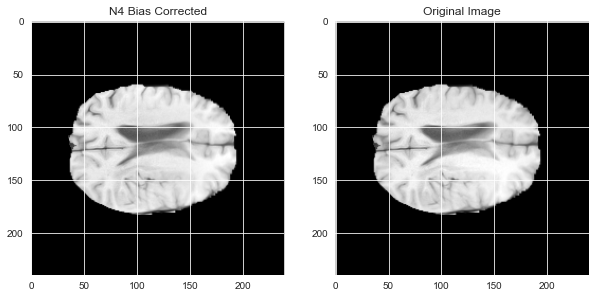

In [48]:
# Plotting original image vs N4 bias corrected - array data
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[1].imshow(image_1_data_arr[:,:,95,1], cmap='gray') # Note modality 1 as one modality was processed
ax[1].set_title("Original Image")
ax[0].imshow(img_corrected_arr[:,:,95], cmap='gray')
ax[0].set_title("N4 Bias Corrected")
plt.show()

#### Note for Sarah: The N4 Bias correction from file doesn't work properly on 4D images (error with otsuthreshold) so we have to convert to np arrays first before doing N4 bias correction and do it for each of the 4 images per MRI. I can run this and it will take a while but we can save the np arrays for easier access in the future. About your note, I think it is still beneficial to remove the top and bottom 1% intensity removal but I will look into it.

In [31]:
image = sitk.ReadImage('data\\train\\' + 'BRATS_001.nii.gz', sitk.sitkFloat32)
print(image.GetWidth())
print(image.GetHeight())
print(image.GetDepth())
print(image.GetDimension())
print (image.GetPixelIDValue())
print (image.GetPixelIDTypeAsString())

240
240
155
4
8
32-bit float


In [14]:
def N4_Bias_Correct_All(src_dir, out_dir):         
    # PROBLEM: Bias correction takes very long. Right now it is accessing an individual channel/modality, performing bias correction and then save this as the FLAIR or T1w or T2w or T1gd file. Use ANTS instead?
    print('N4 bias correction starting...')
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    for data in os.listdir(src_dir):                            
        image = sitk.ReadImage(src_dir + str(data), sitk.sitkFloat32)
          
        inputImg_FLAIR = image[:,:,:,0]                                                                                         
        maskImg_FLAIR = sitk.OtsuThreshold(inputImg_FLAIR, 0, 1, 200)
        outputImg_FLAIR = corrector.Execute(inputImg_FLAIR, maskImg_FLAIR)                   # performing N4 bias correction and normalisation for T1w image               
        sitk.WriteImage(outputImg_FLAIR, out_dir + '\\' + str(data)[:9] + '\\' + 'FLAIR_' + str(data))

        inputImg_T1w = image[:,:,:,1]                                                                                       
        maskImg_T1w = sitk.OtsuThreshold(inputImg_T1w, 0, 1, 200)
        outputImg_T1w = corrector.Execute(inputImg_T1w, maskImg_T1w)                         # performing N4 bias correction and normalisation for T1w image
        sitk.WriteImage(outputImg_T1w, out_dir + '\\' + str(data)[:9] + '\\' + 'T1w_' + str(data))

        inputImg_T1gd  = image[:,:,:,2]                                                          
        maskImg_T1gd = sitk.OtsuThreshold(inputImg_T1gd, 0, 1, 200)
        outputImg_T1gd = corrector.Execute(inputImg_T1gd, maskImg_T1gd)                      # performing N4 bias correction and normalisation for T1gd image
        sitk.WriteImage(outputImg_T1gd, out_dir + '\\' + str(data)[:9] + '\\' + 'T1gd_' + str(data))

        inputImg_T2w  = image[:,:,:,3]                                                            
        maskImg_T2w = sitk.OtsuThreshold(inputImg_T2w, 0, 1, 200)
        outputImg_T2w = corrector.Execute(inputImg_T2w, maskImg_T2w)                         # performing N4 bias correction and normalisation for T1gd image
        sitk.WriteImage(outputImg_T2w, out_dir + '\\' + str(data)[:9] + '\\' + 'T2w_' + str(data))        

        if str(data) == 'BRATS_001.nii.gz':                                                  # Stops after 1 conversion for now
            print('N4 bias correction completed')
            break

In [10]:
start = time.time() 
N4_Bias_Correct_All(src_dir='data\\train\\', out_dir='data\\pre-processed_data\\train')
end = time.time()
print('time taken =', end-start)

N4 bias correction starting...
N4 bias correction completed
time taken = 82.90617752075195


## AARON'S IGNORE SECTION

In [ ]:
print('start')
start = time.time() 
inputImg_FLAIR = sitk.Cast(sitk.GetImageFromArray(image[:,:,:,0]), sitk.sitkFloat32)      # performing N4 bias correction and normalisation for T1w image
#inputImg_FLAIR = image[:,:,:,0]                                                             # sitk.Cast(image[:,:,:,0], sitk.sitkFloat32)                            
maskImg_FLAIR = sitk.OtsuThreshold(inputImg_FLAIR, 0, 1, 200)
outputImg_FLAIR = corrector.Execute(inputImg_FLAIR, maskImg_FLAIR)
mean_FLAIR = np.mean(outputImg_FLAIR, axis=None)
std_FLAIR = np.std(outputImg_FLAIR, axis=None)
normalised_FLAIR = (outputImg_FLAIR - mean_FLAIR) / std_FLAIR                                   
np.save('FLAIR_BRATS_001', normalised_FLAIR)
end = time.time()
print('time taken =', end-start)

In [32]:
def N4_Bias_Correct_All(src_dir, out_dir, msk_dir):
    # Bias correcting all the files in a loop and put them in an output folder and then load them in as arrays. That way you bias correct the whole file. It will take a few minutes to do all of them.
    # UNFINISHED 
    print('Performing N4 bias correction')
    for data in os.listdir(src_dir): 
        InputImg = sitk.ReadImage(src_dir + str(data), sitk.sitkFloat32) 
        #InputImg = sitk.Image(240, 240, 155, sitk.sitkFloat32)                 # This line does not do anything but remap InputImg to a randomly generated image
        #InputImg = sitk.Cast(InputImg, sitk.sitkVectorFloat32)
        MaskImg = sitk.OtsuThreshold(InputImg, 0, 1, 200)                       # ISSUE: having a problem with 4D nature of the data
        sitk.WriteImage(MaskImg, msk_dir)
        corrector = sitk.N4BiasFieldCorrectionImageFilter()
        OutputImg = corrector.Execute(InputImg, MaskImg)
        sitk.WriteImage(OutputImg, out_dir + '\\' + str(data))
        if str(data) == 'BRATS_002.nii.gz':                                     # Stops after 2 files for now
            print('N4 bias correction completed')
            break
N4_Bias_Correct_All(src_dir='data\\train\\', out_dir='data\\pre-processed_data\\train', msk_dir='data\\pre-processed_data\\train_masks')     # N4 bias correction of training images 
N4_Bias_Correct_All(src_dir='data\\train_labels\\', out_dir='data\\pre-processed_data\\train_labels')                                           # N4 bias correction of training labels

def Normalise_All(src_dir, out_dir):     
    # Uses the .nii.gz files after N4 bias corrections, converts to np array and then removes the top and bottom 1% intensities, then normalises to zero mean and unit variance and saves them in the pre-processed_data folder as np arrays. UNFINISHED
    print('Performing Normalisation')
    for data in os.listdir(src_dir): 
        image = os.path.join(src_dir + str(data))               # accessing training image
        image = nib.load(image)                                 # loading the training image
        image_data = image.get_fdata()                          # convert to np array
        mean = np.mean(image_data, axis=None)
        std = np.std(image_data, axis=None)
        norm_volume = (image_data - mean) / std                 # performing normalisation
        if str(data) == 'BRATS_002.nii.gz':                     # stops after 2 files for now
            print('Normalisation completed')
            break
Normalise_All(src_dir='data\\pre-processed_data\\train', out_dir='data\\pre-processed_data\\train')               # Normalisation of training images - overwrites the
Normalise_All(src_dir='data\\pre-processed_data\\train_labels', out_dir='data\\pre-processed_data\\train_labels') # Normalisation of training labels

## U-Net

## Evaluation of U-Net

## Fully Convolutional Network

## Evaluation of Fully Convolutional Network
